# 06.1f: k-NN Density Profile

**Goal:** Map the k-NN density from black hole → exclusion zone → bulk.

Sample representative tokens at different radii and compute their average distance to k nearest neighbors. This reveals the "gravitational potential" - how sparse the neighborhood gets in the void.

**Strategy:**
- Load pre-computed distances from 06.1d
- Select tokens from each radial shell
- For each token, compute k-NN distance
- Plot k-NN vs radius

Expected pattern:
- k-NN ≈ 0 at singularity (degenerate)
- k-NN spikes in exclusion zone (vacuum)
- k-NN smoothly increases in bulk (Gaussian cloud)

This is Volume 6: Pathologies and Singularities

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
DISTANCES_FILE = "black_hole_distances_qwen3_4b_instruct_2507.safetensors"

# Radial shells for sampling
SHELLS = [
    0.000001,   # Black hole core
    0.00001,    # Near-degenerate
    0.0001,     # Accretion disk edge
    0.0005,     # Early exclusion zone
    0.001,
    0.005,
    0.01,
    0.05,       # Mid exclusion zone (phase transition?)
    0.1,        # Bulk begins
    0.2,
    0.3,
    0.5,
    0.7,
    1.0,
    1.2,
    1.5,
]

# k-NN parameters
K_NEIGHBORS = 30

# Sampling: how many tokens to sample per shell
SAMPLES_PER_SHELL = 20  # More samples for better statistics

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
# Load distances
distances_path = Path(TENSOR_DIR) / DISTANCES_FILE
data = load_file(distances_path)
distances = data['distances']
reference_token_id = data['reference_token_id'].item()

N = len(distances)

print(f"Loaded distances from: {DISTANCES_FILE}")
print(f"  Tokens: {N:,}")
print(f"  Reference token: {reference_token_id}")
print()

# Load gamma prime (need full embeddings for k-NN computation)
gamma_prime_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_prime = load_file(gamma_prime_path)['gamma_centered']

print(f"Loaded γ' (centered):")
print(f"  Shape: {gamma_prime.shape}")

Loaded distances from: black_hole_distances_qwen3_4b_instruct_2507.safetensors
  Tokens: 151,936
  Reference token: 149415

Loaded γ' (centered):
  Shape: torch.Size([151936, 2560])


## Step 2: Sample Tokens from Each Shell

In [4]:
print("\n" + "="*70)
print("SAMPLING TOKENS FROM RADIAL SHELLS")
print("="*70)
print()

# Create shell boundaries
shell_edges = [0] + SHELLS

# Sample tokens from each shell
sampled_tokens = []

print(f"{'Shell':^6} {'r_inner':>12} {'r_outer':>12} {'Total':>8} {'Sampled':>8}")
print("-" * 70)

for i in range(len(shell_edges) - 1):
    r_inner = shell_edges[i]
    r_outer = shell_edges[i + 1]
    
    # Find tokens in this shell
    in_shell = (distances > r_inner) & (distances <= r_outer)
    shell_indices = torch.where(in_shell)[0]
    n_in_shell = len(shell_indices)
    
    if n_in_shell == 0:
        print(f"{i:^6} {r_inner:>12.6f} {r_outer:>12.6f} {n_in_shell:>8,} {0:>8}")
        continue
    
    # Sample up to SAMPLES_PER_SHELL tokens
    n_sample = min(SAMPLES_PER_SHELL, n_in_shell)
    
    if n_sample < n_in_shell:
        # Random sample
        perm = torch.randperm(n_in_shell)[:n_sample]
        sampled_indices = shell_indices[perm]
    else:
        # Use all tokens in shell
        sampled_indices = shell_indices
    
    # Store with shell metadata
    for idx in sampled_indices:
        sampled_tokens.append({
            'shell_idx': i,
            'token_id': idx.item(),
            'radius': distances[idx].item(),
            'r_mid': (r_inner + r_outer) / 2,
        })
    
    print(f"{i:^6} {r_inner:>12.6f} {r_outer:>12.6f} {n_in_shell:>8,} {n_sample:>8}")

print()
print(f"Total sampled tokens: {len(sampled_tokens):,}")


SAMPLING TOKENS FROM RADIAL SHELLS

Shell       r_inner      r_outer    Total  Sampled
----------------------------------------------------------------------
  0        0.000000     0.000001       20       20
  1        0.000001     0.000010        8        8
  2        0.000010     0.000100    1,341       20
  3        0.000100     0.000500       23       20
  4        0.000500     0.001000        4        4
  5        0.001000     0.005000        4        4
  6        0.005000     0.010000        7        7
  7        0.010000     0.050000       80       20
  8        0.050000     0.100000      285       20
  9        0.100000     0.200000      457       20
  10       0.200000     0.300000      522       20
  11       0.300000     0.500000    1,350       20
  12       0.500000     0.700000    2,483       20
  13       0.700000     1.000000   24,755       20
  14       1.000000     1.200000  100,511       20
  15       1.200000     1.500000   19,271       20

Total sampled tokens: 26

## Step 3: Compute k-NN Density for Each Sampled Token

In [5]:
print("\n" + "="*70)
print(f"COMPUTING k-NN DENSITY (k={K_NEIGHBORS})")
print("="*70)
print()

# Compute k-NN for each sampled token
for token_info in tqdm(sampled_tokens, desc="Computing k-NN distances"):
    token_id = token_info['token_id']
    token_embedding = gamma_prime[token_id]
    
    # Compute distances to all other tokens
    dists = torch.norm(gamma_prime - token_embedding, dim=1)
    
    # Get k+1 nearest (including self at distance 0)
    k_nearest_dists = torch.topk(dists, k=K_NEIGHBORS + 1, largest=False).values
    
    # Exclude self, take mean
    mean_knn_dist = k_nearest_dists[1:].mean().item()
    
    token_info['knn_mean'] = mean_knn_dist

print(f"\nComputed k-NN for {len(sampled_tokens):,} tokens")


COMPUTING k-NN DENSITY (k=30)



Computing k-NN distances: 100%|██████████| 263/263 [00:18<00:00, 13.91it/s]


Computed k-NN for 263 tokens


## Step 4: Aggregate by Shell

In [6]:
print("\n" + "="*70)
print("k-NN DENSITY BY SHELL")
print("="*70)
print()

# Group by shell and compute statistics
shell_stats = {}
for token_info in sampled_tokens:
    shell_idx = token_info['shell_idx']
    if shell_idx not in shell_stats:
        shell_stats[shell_idx] = {
            'r_mid': token_info['r_mid'],
            'knn_values': [],
        }
    shell_stats[shell_idx]['knn_values'].append(token_info['knn_mean'])

# Compute mean and std for each shell
shell_results = []
for shell_idx in sorted(shell_stats.keys()):
    stats = shell_stats[shell_idx]
    knn_values = np.array(stats['knn_values'])
    
    shell_results.append({
        'shell_idx': shell_idx,
        'r_mid': stats['r_mid'],
        'knn_mean': knn_values.mean(),
        'knn_std': knn_values.std(),
        'knn_min': knn_values.min(),
        'knn_max': knn_values.max(),
        'n_samples': len(knn_values),
    })

print(f"{'Shell':^6} {'r_mid':>12} {'k-NN Mean':>12} {'k-NN Std':>12} {'n':>6}")
print("-" * 70)

for result in shell_results:
    print(f"{result['shell_idx']:^6} {result['r_mid']:>12.6f} {result['knn_mean']:>12.6f} "
          f"{result['knn_std']:>12.6f} {result['n_samples']:>6}")


k-NN DENSITY BY SHELL

Shell         r_mid    k-NN Mean     k-NN Std      n
----------------------------------------------------------------------
  0        0.000000     0.000000     0.000000     20
  1        0.000006     0.000004     0.000002      8
  2        0.000055     0.000000     0.000000     20
  3        0.000300     0.000232     0.000131     20
  4        0.000750     0.000805     0.000165      4
  5        0.003000     0.002331     0.001305      4
  6        0.007500     0.007882     0.001312      7
  7        0.030000     0.035055     0.009542     20
  8        0.075000     0.074079     0.013692     20
  9        0.150000     0.151408     0.029028     20
  10       0.250000     0.243383     0.029417     20
  11       0.400000     0.391463     0.048422     20
  12       0.600000     0.582084     0.066934     20
  13       0.850000     0.881865     0.077096     20
  14       1.100000     1.068080     0.054221     20
  15       1.350000     1.236793     0.039534     20


## Step 5: Visualize k-NN Density Profile


k-NN DENSITY PROFILE



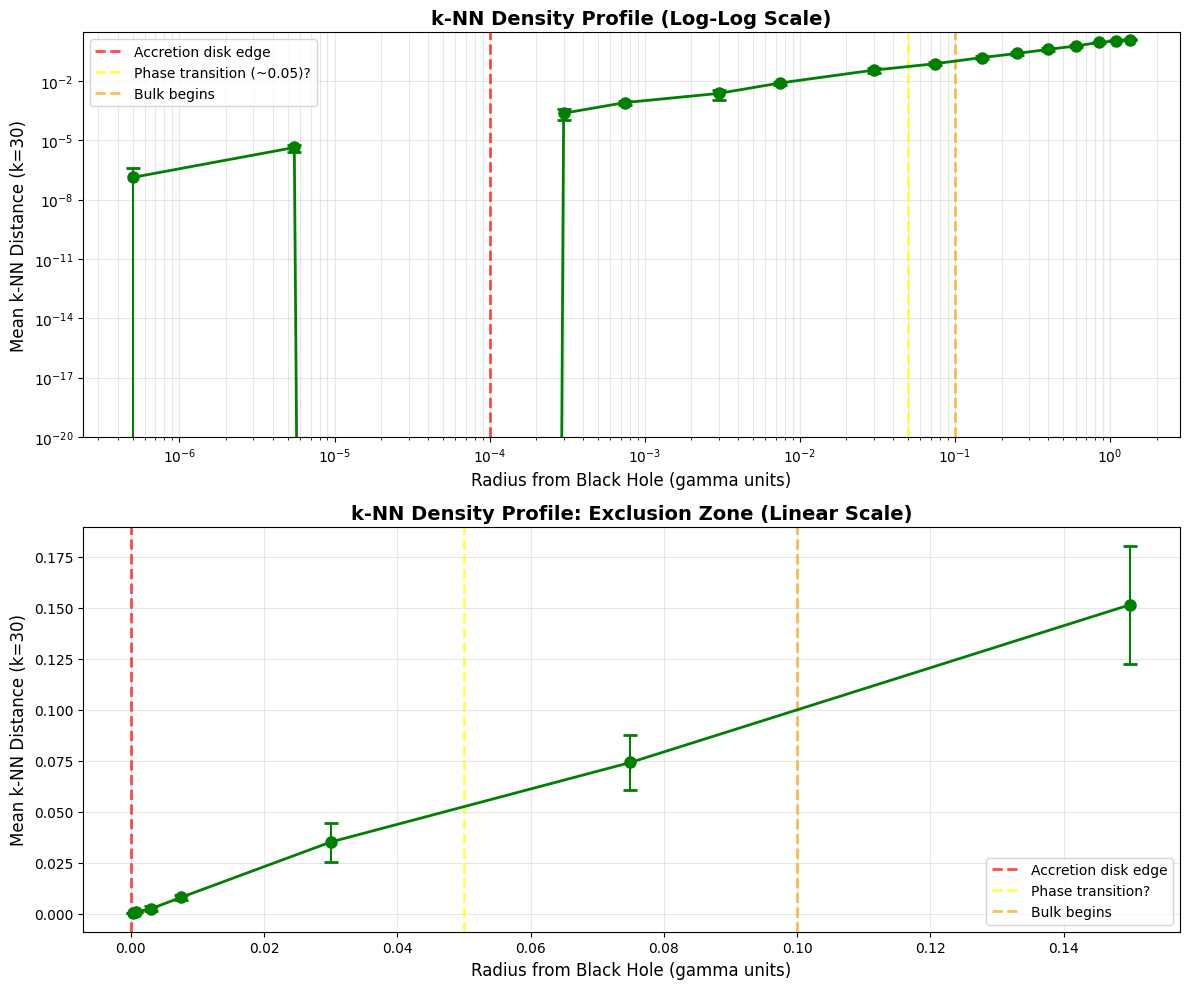


Interpretation:
  - k-NN ≈ 0 at singularity: degenerate embeddings
  - k-NN jumps in exclusion zone: tokens far from neighbors
  - k-NN increases smoothly in bulk: normal density gradient

Look for anomalies around r=0.05 (potential phase transition)


In [19]:
print("\n" + "="*70)
print("k-NN DENSITY PROFILE")
print("="*70)
print()

# Extract data for plotting
r_mids = [r['r_mid'] for r in shell_results]
knn_means = [r['knn_mean'] for r in shell_results]
knn_stds = [r['knn_std'] for r in shell_results]

fig, axes = plt.subplots(2, 1, figsize=(12, 10), dpi=100)

# Top: Log-log scale (full range)
axes[0].errorbar(r_mids, knn_means, yerr=knn_stds, 
                 marker='o', color='green', linewidth=2, markersize=8,
                 capsize=5, capthick=2, elinewidth=1.5)
axes[0].set_xlabel('Radius from Black Hole (gamma units)', fontsize=12)
axes[0].set_ylabel(f'Mean k-NN Distance (k={K_NEIGHBORS})', fontsize=12)
axes[0].set_title('k-NN Density Profile (Log-Log Scale)', fontsize=14, fontweight='bold')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylim(bottom=1e-20)
axes[0].grid(True, alpha=0.3, which='both')

# Mark key regions
axes[0].axvline(0.0001, color='red', linestyle='--', linewidth=2, alpha=0.7, 
                label='Accretion disk edge')
axes[0].axvline(0.05, color='yellow', linestyle='--', linewidth=2, alpha=0.7,
                label='Phase transition (~0.05)?')
axes[0].axvline(0.1, color='orange', linestyle='--', linewidth=2, alpha=0.7, 
                label='Bulk begins')
axes[0].legend(fontsize=10)

# Bottom: Linear scale (zoomed to exclusion zone)
# Only show shells in exclusion zone + nearby
exclusion_mask = [(0.0001 <= r <= 0.2) for r in r_mids]
r_exclusion = [r for r, m in zip(r_mids, exclusion_mask) if m]
knn_exclusion = [k for k, m in zip(knn_means, exclusion_mask) if m]
std_exclusion = [s for s, m in zip(knn_stds, exclusion_mask) if m]

axes[1].errorbar(r_exclusion, knn_exclusion, yerr=std_exclusion,
                 marker='o', color='green', linewidth=2, markersize=8,
                 capsize=5, capthick=2, elinewidth=1.5)
axes[1].set_xlabel('Radius from Black Hole (gamma units)', fontsize=12)
axes[1].set_ylabel(f'Mean k-NN Distance (k={K_NEIGHBORS})', fontsize=12)
axes[1].set_title('k-NN Density Profile: Exclusion Zone (Linear Scale)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[1].axvline(0.0001, color='red', linestyle='--', linewidth=2, alpha=0.7,
                label='Accretion disk edge')
axes[1].axvline(0.05, color='yellow', linestyle='--', linewidth=2, alpha=0.7,
                label='Phase transition?')
axes[1].axvline(0.1, color='orange', linestyle='--', linewidth=2, alpha=0.7,
                label='Bulk begins')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - k-NN ≈ 0 at singularity: degenerate embeddings")
print("  - k-NN jumps in exclusion zone: tokens far from neighbors")
print("  - k-NN increases smoothly in bulk: normal density gradient")
print("\nLook for anomalies around r=0.05 (potential phase transition)")

## Step 6: Identify Density Transitions

In [20]:
print("\n" + "="*70)
print("k-NN DENSITY TRANSITIONS")
print("="*70)
print()

print(f"{'Transition':^30} {'k-NN Ratio':>15} {'Interpretation':^25}")
print("-" * 70)

for i in range(len(shell_results) - 1):
    r1 = shell_results[i]
    r2 = shell_results[i + 1]
    
    if r1['knn_mean'] > 0:
        ratio = r2['knn_mean'] / r1['knn_mean']
        
        if ratio > 2:
            interpretation = "Sharp jump (rarefaction)"
        elif ratio < 0.5:
            interpretation = "Sharp drop (densification)"
        else:
            interpretation = "Smooth transition"
        
        transition = f"{r1['r_mid']:.6f} → {r2['r_mid']:.6f}"
        print(f"{transition:^30} {ratio:>15.2f}× {interpretation:^25}")

print()
print("Ratios > 2× indicate rarefaction (tokens getting isolated)")
print("Ratios < 0.5× indicate densification (entering denser region)")


k-NN DENSITY TRANSITIONS

          Transition                k-NN Ratio      Interpretation      
----------------------------------------------------------------------
     0.000000 → 0.000006                 32.49× Sharp jump (rarefaction) 
     0.000006 → 0.000055                  0.00× Sharp drop (densification)
     0.000300 → 0.000750                  3.47× Sharp jump (rarefaction) 
     0.000750 → 0.003000                  2.89× Sharp jump (rarefaction) 
     0.003000 → 0.007500                  3.38× Sharp jump (rarefaction) 
     0.007500 → 0.030000                  4.45× Sharp jump (rarefaction) 
     0.030000 → 0.075000                  2.11× Sharp jump (rarefaction) 
     0.075000 → 0.150000                  2.04× Sharp jump (rarefaction) 
     0.150000 → 0.250000                  1.61×     Smooth transition    
     0.250000 → 0.400000                  1.61×     Smooth transition    
     0.400000 → 0.600000                  1.49×     Smooth transition    
     0.600000 

## Summary

k-NN density profiling reveals the "gravitational potential" around the singularity:

### Expected Structure:

1. **Singularity (r ≈ 0)**: k-NN ≈ 0 (degenerate embeddings)
2. **Accretion disk (r < 0.0001)**: k-NN very small (ultra-dense)
3. **Exclusion zone (0.0001 < r < 0.1)**: k-NN jumps up (vacuum - tokens isolated from neighbors)
4. **Bulk cloud (r > 0.1)**: k-NN increases smoothly with radius (normal Gaussian-like density)

### Key Findings:

Look for:
- **Sharp k-NN jump** at accretion disk edge (r ≈ 0.0001)
- **High k-NN plateau** in exclusion zone (tokens are isolated)
- **Potential phase transition** around r ≈ 0.05 (visible in histogram)
- **Smooth k-NN increase** in bulk (proportional to radius)

This confirms the exclusion zone is a true vacuum - tokens there have distant neighbors, unlike the ultra-dense core or the crowded bulk.